# Arabic Handwritten Characters Recognition
#### In this project we will employ deep learning model to classify the images to an arabic letter.

## Dataset
#### The dataset for this project originates from kaggle kernels which include [Arabic Letters](http://https://www.kaggle.com/mloey1/ahcd1).
#### All the datasets are CSV files representing the image pixels values and their corresponding label.

**Arabic Letters Dataset is composed of 16,800 characters written by 60 participants,** the age range is between 19 to 40 years, and 90% of participants are right-hand. Each participant wrote each character (from 'alef' to 'yeh') ten times. The images were scanned at the resolution of 300 dpi. Each block is segmented automatically using Matlab 2016a to determining the coordinates for each block. **The dataset is partitioned into two sets: a training set of 13,440 characters to 480 images per class and a test set of 3,360 characters to 120 images per class.** Writers of training set and test set are exclusive. Ordering of including writers to test set are randomized to make sure that writers of test set are not from a single institution to ensure variability of the test set.


## Data Exploration
#### Import libraries necessary for this project.


In [30]:
# Import main libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames

# Import libraries needed for reading image and processing it
import csv
from PIL import Image
from scipy.ndimage import rotate

# Pretty display for notebooks
%matplotlib inline

#### Load Arabic Letters dataset files into dataframes

In [31]:
# Training letters images and labels files
letters_training_images_file_path = "../input/ahcd1/csvTrainImages 13440x1024.csv"
letters_training_labels_file_path = "../input/ahcd1/csvTrainLabel 13440x1.csv"
# Testing letters images and labels files
letters_testing_images_file_path = "../input/ahcd1/csvTestImages 3360x1024.csv"
letters_testing_labels_file_path = "../input/ahcd1/csvTestLabel 3360x1.csv"

# Loading dataset into dataframes
training_letters_images = pd.read_csv(letters_training_images_file_path, header=None)
training_letters_labels = pd.read_csv(letters_training_labels_file_path, header=None)
testing_letters_images = pd.read_csv(letters_testing_images_file_path, header=None)
testing_letters_labels = pd.read_csv(letters_testing_labels_file_path, header=None)

# print statistics about the dataset
print("There are %d training arabic letter images of 32x32 pixels." %training_letters_images.shape[0])
print("There are %d testing arabic letter images of 32x32 pixels." %testing_letters_images.shape[0])
training_letters_images.head()

There are 13440 training arabic letter images of 32x32 pixels.
There are 3360 testing arabic letter images of 32x32 pixels.


,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Convert csv values to an image
Writting a method to be used later if we want visualization of an image from its pixels values.

In [32]:
def convert_values_to_image(image_values, display=False):
    image_array = np.asarray(image_values)
    image_array = image_array.reshape(32,32).astype('uint8')
    # The original dataset is reflected so we will flip it then rotate for a better view only.
    image_array = np.flip(image_array, 0)
    image_array = rotate(image_array, -90)
    new_image = Image.fromarray(image_array)
    if display == True:
        new_image.show()
    return new_image

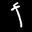

In [33]:
convert_values_to_image(training_letters_images.loc[0], True)

## Data Preprocessing
### Image Normalization <br/>
**We rescale the images by dividing every pixel in the image by 255 to make them into range [0, 1]

In [34]:
training_letters_images_scaled = training_letters_images.values.astype('float32')/255
training_letters_labels = training_letters_labels.values.astype('int32')
testing_letters_images_scaled = testing_letters_images.values.astype('float32')/255
testing_letters_labels = testing_letters_labels.values.astype('int32')

In [35]:
print("Training images of letters after scaling")
print(training_letters_images_scaled.shape)
training_letters_images_scaled[0:5]

Training images of letters after scaling
(13440, 1024)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## Encoding Categorical Labels
#### From the labels csv files we can see that labels are categorical values and it is a multi-class classification problem.
**the outputs are in the form of:
Letters from 'alef' to 'yeh' have categories numbers from 0 to 27**<br/>
### Here we will encode these categories values using One Hot Encoding with keras.

One-hot encoding transforms integer to a binary matrix where the array contains only one ‘1’ and the rest elements are ‘0’.

In [36]:
from keras.utils import to_categorical

# one hot encoding
# number of classes = 28 (arabic alphabet classes)
number_of_classes = 28

training_letters_labels_encoded = to_categorical(training_letters_labels-1, num_classes=number_of_classes)
testing_letters_labels_encoded = to_categorical(testing_letters_labels-1, num_classes=number_of_classes)

In [37]:
print(training_letters_labels_encoded)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


## Reshaping Input Images to 32x32x1
When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape (nb_samples,rows,columns,channels)

where nb_samples corresponds to the total number of images (or samples), and rows, columns, and channels correspond to the number of rows, columns, and channels for each image, respectively.

So we will reshape the input images to a 4D tensor with shape (nb_samples, 32, 32 ,1) as we use grayscale images of 32x32 pixels.

In [38]:
# reshape input letter images to 32x32x1
training_letters_images_scaled = training_letters_images_scaled.reshape([-1, 32, 32, 1])
testing_letters_images_scaled = testing_letters_images_scaled.reshape([-1, 32, 32, 1])

print(training_letters_images_scaled.shape, training_letters_labels_encoded.shape, testing_letters_images_scaled.shape, testing_letters_labels_encoded.shape)

(13440, 32, 32, 1) (13440, 28) (3360, 32, 32, 1) (3360, 28)


## Designing Model Architecture

In [39]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Dropout, Dense

def create_model(optimizer='adam', kernel_initializer='he_normal', activation='relu'):
    # create model
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=3, padding='same', input_shape=(32, 32, 1), kernel_initializer=kernel_initializer, activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=32, kernel_size=3, padding='same', kernel_initializer=kernel_initializer, activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=64, kernel_size=3, padding='same', kernel_initializer=kernel_initializer, activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=128, kernel_size=3, padding='same', kernel_initializer=kernel_initializer, activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(GlobalAveragePooling2D())

    #Fully connected final layer
    model.add(Dense(28, activation='softmax'))

    # Compile model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
    return model

**above code step by step.**

* The first hidden layer is a convolutional layer. The layer has 16 feature maps, which with the size of 3×3 and an activation function which is relu. This is the input layer, expecting images with the structure outlined above.
* The second layer is Batch Normalization which solves having distributions of the features vary across the training and test data, which breaks the IID assumption. We use it to help in two ways faster learning and higher overall accuracy.
* The third layer is the MaxPooling layer. MaxPooling layer is used to down-sample the input to enable the model to make assumptions about the features so as to reduce overfitting. It also reduces the number of parameters to learn, reducing the training time.
* The next layer is a Regularization layer using dropout. It is configured to randomly exclude 20% of neurons in the layer in order to reduce overfitting.
* Another hidden layer with 32 feature maps with the size of 3×3 and a relu activation function to capture more features from the image.
* Other hidden layers with 64 and 128 feature maps with the size of 3×3 and a relu activation function to capture complex patterns from the image which will decribe the digits and letters later.
* More MaxPooling, Batch Normalization, Regularization and GlobalAveragePooling2D layers.
* The last layer is the output layer with (number of output classes) and it uses softmax activation function as we have multi-classes. Each neuron will give the probability of that class.
* I used categorical_crossentropy as a loss function because its a multi-class classification problem. I used accuracy as metrics to improve the performance of our neural network.

## Model Summary And Visualization

In [40]:
model = create_model()
model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_105 (Conv2D)          (None, 32, 32, 16)        160       
_________________________________________________________________
batch_normalization_105 (Bat (None, 32, 32, 16)        64        
_________________________________________________________________
max_pooling2d_105 (MaxPoolin (None, 16, 16, 16)        0         
_________________________________________________________________
dropout_105 (Dropout)        (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 16, 16, 32)        4640      
_________________________________________________________________
batch_normalization_106 (Bat (None, 16, 16, 32)        128       
_________________________________________________________________
max_pooling2d_106 (MaxPoolin (None, 8, 8, 32)        

**Keras support plotting the model in keras.utils.vis_utils module which provides utility functions to plot a Keras model using graphviz.**

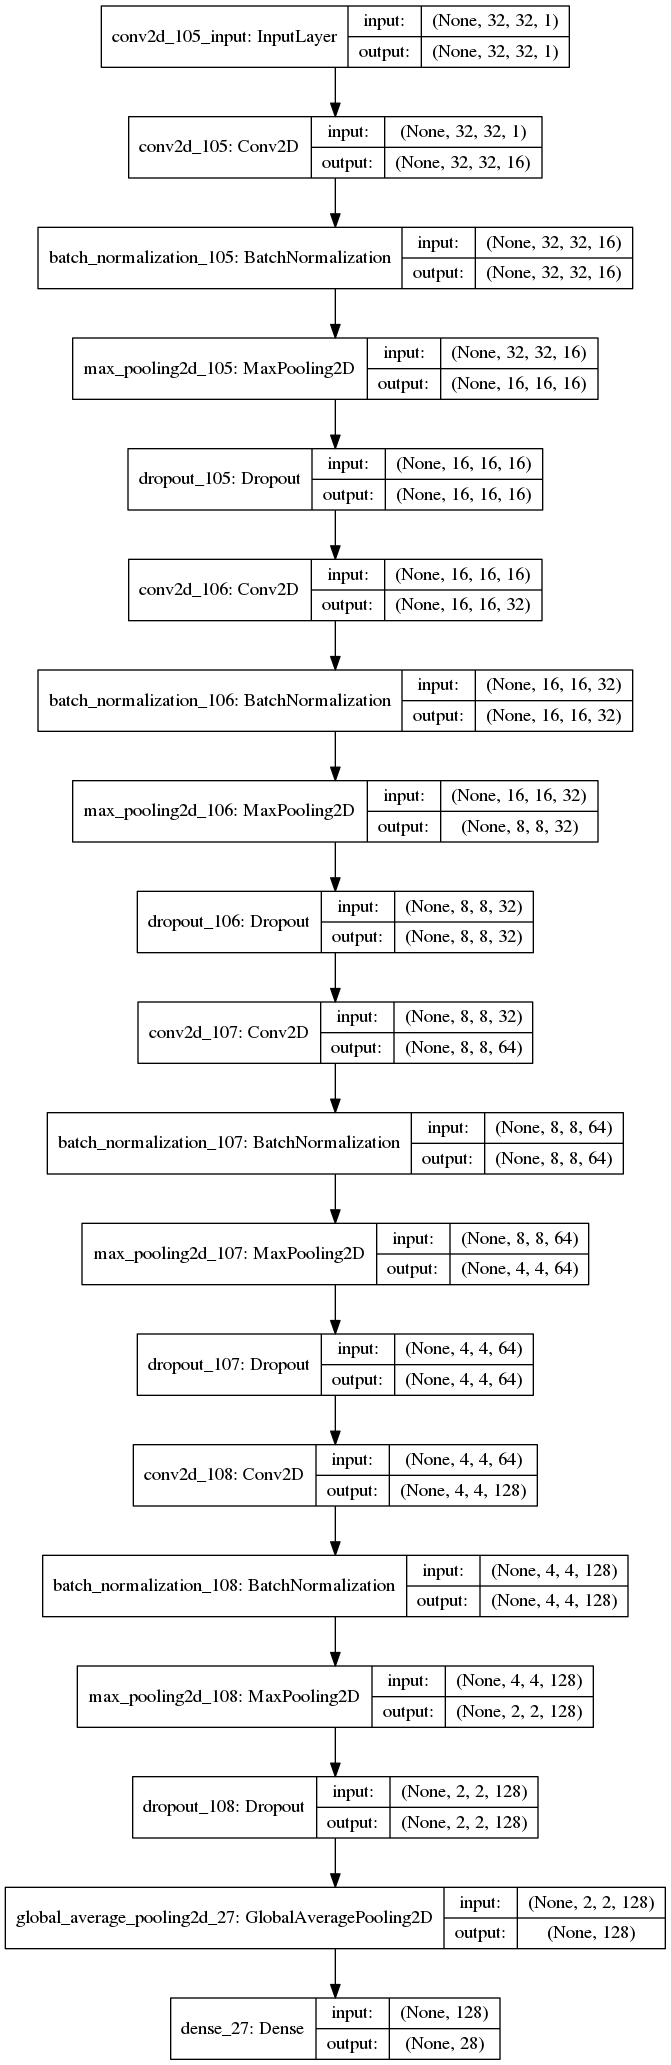

In [41]:
import pydot
from keras.utils import plot_model

plot_model(model, to_file="model.png", show_shapes=True)
from IPython.display import Image as IPythonImage
display(IPythonImage('model.png'))

## Parameters Tuning

In [42]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# define the grid search parameters
optimizer = ['RMSprop', 'Adam', 'Adagrad', 'Nadam']
kernel_initializer = ['normal', 'uniform']
activation = ['relu', 'linear', 'tanh']

param_grid = dict(optimizer=optimizer, kernel_initializer=kernel_initializer, activation=activation)

# count number of different parameters values combinations
parameters_number = 1
for x in param_grid:
    parameters_number = parameters_number * len(param_grid[x]) 
print("Number of different parameter combinations = {}".format(parameters_number))

Number of different parameter combinations = 24


**We will try different models with different parameters to find the best parameter values.**

In [43]:
epochs = 5
batch_size = 20 # 20 divides the training data samples

#creating the models with different hyperparameters
for a,b,c in [(x,y,z) for x in optimizer for z in activation for y in kernel_initializer]:
    params = {'optimizer' : a , 'kernel_initializer' : b , 'activation' : c}
    print(params)
    curr_model = create_model(a, b, c)
    curr_model.fit(training_letters_images_scaled, training_letters_labels_encoded, 
                    validation_data=(testing_letters_images_scaled, testing_letters_labels_encoded),
                    epochs=epochs, batch_size=batch_size, verbose=1)
    print("=============================================================================")

{'optimizer': 'RMSprop', 'kernel_initializer': 'normal', 'activation': 'relu'}
Train on 13440 samples, validate on 3360 samples
Epoch 1/5
13440/13440 [==============================] - 10s 718us/step - loss: 1.3945 - accuracy: 0.5660 - val_loss: 1.6413 - val_accuracy: 0.5063
Epoch 2/5
13440/13440 [==============================] - 8s 621us/step - loss: 0.5182 - accuracy: 0.8267 - val_loss: 0.3275 - val_accuracy: 0.8988
Epoch 3/5
13440/13440 [==============================] - 8s 585us/step - loss: 0.3721 - accuracy: 0.8759 - val_loss: 0.4539 - val_accuracy: 0.8515
Epoch 4/5
13440/13440 [==============================] - 8s 578us/step - loss: 0.3135 - accuracy: 0.8961 - val_loss: 0.2162 - val_accuracy: 0.9301
Epoch 5/5
13440/13440 [==============================] - 8s 583us/step - loss: 0.2750 - accuracy: 0.9117 - val_loss: 0.2018 - val_accuracy: 0.9387
{'optimizer': 'RMSprop', 'kernel_initializer': 'uniform', 'activation': 'relu'}
Train on 13440 samples, validate on 3360 samples
Epoch 1

<strong>From the above results we can see that best parameters are:
* Optimizer: Adam
* Kernel_initializer: uniform
* Activation: relu
</strong>
<br/>
Let's create the model with the best parameters obtained.

In [44]:
model = create_model(optimizer='Adam', kernel_initializer='uniform', activation='relu')


## Training the Model
### Fitting the Model
<strong>Train the model using batch_size=30 to reduce used memory and make the training more quick. We will train the model first on 15 epochs to see the accuracy that we will obtain</strong>

In [45]:
from keras.callbacks import ModelCheckpoint  

# using checkpoints to save model weights to be used later instead of training again on the same epochs.
checkpointer = ModelCheckpoint(filepath='weights.hdf5', verbose=1, save_best_only=True)
history = model.fit(training_letters_images_scaled, training_letters_labels_encoded, 
                    validation_data=(testing_letters_images_scaled, testing_letters_labels_encoded),
                    epochs=15, batch_size=20, verbose=1, callbacks=[checkpointer])

Train on 13440 samples, validate on 3360 samples
Epoch 1/15
13440/13440 [==============================] - 11s 794us/step - loss: 1.3670 - accuracy: 0.5798 - val_loss: 1.0002 - val_accuracy: 0.6872

Epoch 00001: val_loss improved from inf to 1.00020, saving model to weights.hdf5
Epoch 2/15
13440/13440 [==============================] - 9s 678us/step - loss: 0.5027 - accuracy: 0.8380 - val_loss: 0.2792 - val_accuracy: 0.9155

Epoch 00002: val_loss improved from 1.00020 to 0.27920, saving model to weights.hdf5
Epoch 3/15
13440/13440 [==============================] - 9s 654us/step - loss: 0.3616 - accuracy: 0.8815 - val_loss: 0.5661 - val_accuracy: 0.8104

Epoch 00003: val_loss did not improve from 0.27920
Epoch 4/15
13440/13440 [==============================] - 9s 641us/step - loss: 0.3070 - accuracy: 0.9003 - val_loss: 0.7259 - val_accuracy: 0.7952

Epoch 00004: val_loss did not improve from 0.27920
Epoch 5/15
13440/13440 [==============================] - 9s 656us/step - loss: 0.2684

## Plotting Loss and Accuracy Curves with Epochs

In [46]:
import matplotlib.pyplot as plt

def plot_loss_accuracy(history):
    # Loss Curves
    plt.figure(figsize=[8,6])
    plt.plot(history.history['loss'],'r',linewidth=3.0)
    plt.plot(history.history['val_loss'],'b',linewidth=3.0)
    plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Loss',fontsize=16)
    plt.title('Loss Curves',fontsize=16)

    # Accuracy Curves
    plt.figure(figsize=[8,6])
    plt.plot(history.history['accuracy'],'r',linewidth=3.0)
    plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
    plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)
    plt.title('Accuracy Curves',fontsize=16) 

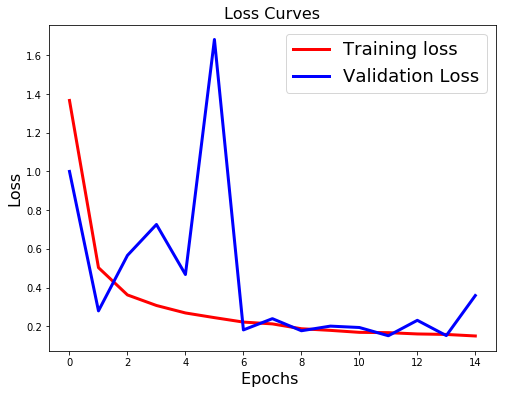

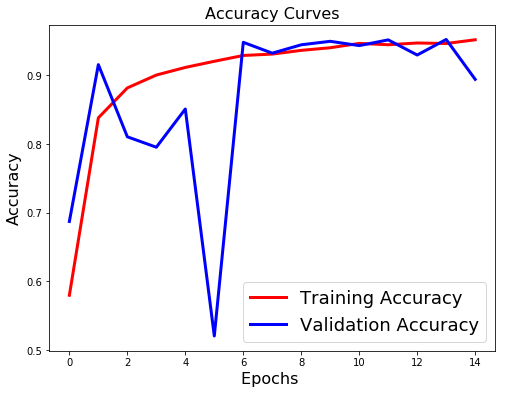

In [47]:
plot_loss_accuracy(history)

### Load the Model with the Best Validation Loss

In [48]:
model.load_weights('weights.hdf5')

## Test the Model

In [49]:
# Final evaluation of the model
metrics = model.evaluate(testing_letters_images_scaled, testing_letters_labels_encoded, verbose=1)
print("Test Accuracy: {}".format(metrics[1]))
print("Test Loss: {}".format(metrics[0]))

3360/3360 [==============================] - 0s 115us/step
Test Accuracy: 0.9514880776405334
Test Loss: 0.15055975043880088


### We get test accuracy of 95.14% after training on 10 epochs only

#### What about increasing the epochs we train on ?

Train on 13440 samples, validate on 3360 samples
Epoch 1/30
13440/13440 [==============================] - 9s 661us/step - loss: 0.1257 - accuracy: 0.9598 - val_loss: 0.1519 - val_accuracy: 0.9571

Epoch 00001: val_loss improved from inf to 0.15194, saving model to weights.hdf5
Epoch 2/30
13440/13440 [==============================] - 9s 664us/step - loss: 0.1180 - accuracy: 0.9591 - val_loss: 0.1300 - val_accuracy: 0.9646

Epoch 00002: val_loss improved from 0.15194 to 0.12997, saving model to weights.hdf5
Epoch 3/30
13440/13440 [==============================] - 9s 670us/step - loss: 0.1065 - accuracy: 0.9657 - val_loss: 0.3577 - val_accuracy: 0.8765

Epoch 00003: val_loss did not improve from 0.12997
Epoch 4/30
13440/13440 [==============================] - 10s 709us/step - loss: 0.1025 - accuracy: 0.9653 - val_loss: 0.2069 - val_accuracy: 0.9381

Epoch 00004: val_loss did not improve from 0.12997
Epoch 5/30
13440/13440 [==============================] - 10s 708us/step - loss: 0.110

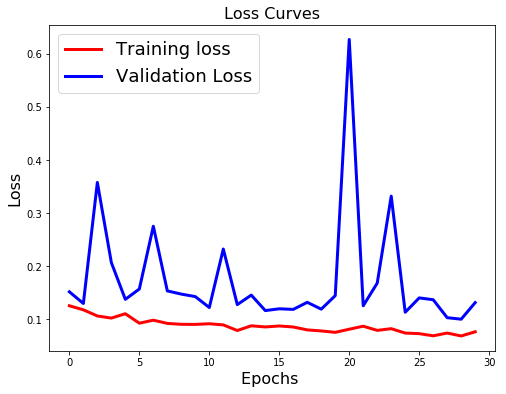

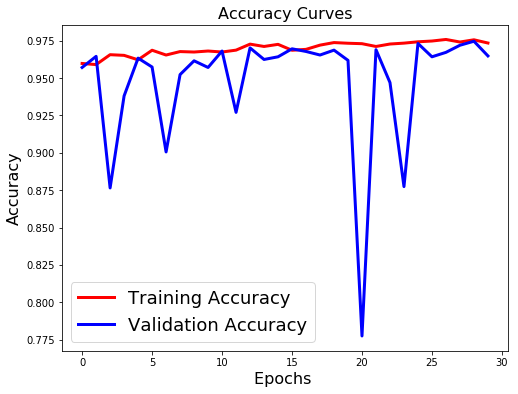

In [53]:
epochs = 30
batch_size = 20

checkpointer = ModelCheckpoint(filepath='weights.hdf5', verbose=1, save_best_only=True)

history = model.fit(training_letters_images_scaled, training_letters_labels_encoded, 
                    validation_data=(testing_letters_images_scaled, testing_letters_labels_encoded),
                    epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[checkpointer])
          
model.load_weights('weights.hdf5')
plot_loss_accuracy(history)

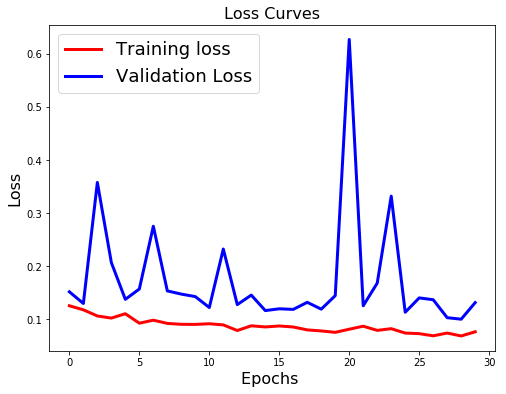

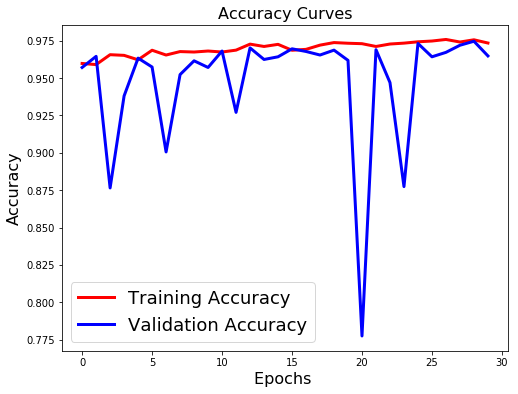

In [54]:
plot_loss_accuracy(history)

## Testing the Model again

In [55]:
# Final evaluation of the model
metrics = model.evaluate(testing_letters_images_scaled, testing_letters_labels_encoded, verbose=1)
print("Test Accuracy: {}".format(metrics[1]))
print("Test Loss: {}".format(metrics[0]))

3360/3360 [==============================] - 0s 107us/step
Test Accuracy: 0.9747023582458496
Test Loss: 0.10040796469478491


After training the model on more epochs we gained a better model which can classify complex patterns. So when we tested it on our test dataset we had better results than before.

**Test accuracy is improved from 95.14% to 97.47% As we train the model on 20 more epochs.**

## Saving the Final Model
#### Let's save the model on json format to be used later instead of creating the model again from scratch.

In [56]:
from keras.models import model_from_yaml
model_yaml = model.to_yaml()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)

#### Save the model weights to file.

In [57]:
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


#### if we want to load the model with the last obtained weights at anytime, we will run the following code cell.

In [59]:
# load YAML and create model
yaml_file = open('model.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
loaded_model = model_from_yaml(loaded_model_yaml)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# compile the loaded model
loaded_model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

Loaded model from disk


## Predict Image Classes
<strong>Making a method which takes a model, data and its true labels (optional for using in testing). Then it gives the predicted classes of the given data using the given model.</strong>

In [74]:
def get_predicted_classes(model, data, labels=None):
    image_predictions = model.predict(data)
    predicted_classes = np.argmax(image_predictions, axis=1)
    true_classes = np.argmax(labels, axis=1)
    return predicted_classes, true_classes, image_predictions

#### Making a method which will print all metrics (precision, recall, f1-score and support) with each class in the dataset.

In [75]:
from sklearn.metrics import classification_report

def get_classification_report(y_true, y_pred):
    print(classification_report(y_true, y_pred))

In [76]:
y_pred, y_true, image_predictions = get_predicted_classes(model, testing_letters_images_scaled, testing_letters_labels_encoded)
get_classification_report(y_true, y_pred)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       120
           1       1.00      0.99      1.00       120
           2       0.92      0.97      0.94       120
           3       0.97      0.96      0.97       120
           4       0.99      0.99      0.99       120
           5       0.98      0.98      0.98       120
           6       0.99      0.99      0.99       120
           7       0.97      0.95      0.96       120
           8       0.96      0.94      0.95       120
           9       0.92      1.00      0.96       120
          10       0.96      0.93      0.94       120
          11       0.99      1.00      1.00       120
          12       0.99      1.00      1.00       120
          13       0.97      0.99      0.98       120
          14       1.00      0.95      0.97       120
          15       0.96      1.00      0.98       120
          16       1.00      0.96      0.98       120
          17       0.96    

In [ ]:
errors = (y_pred - y_true != 0)


Y_pred_classes_errors = y_pred[errors]
Y_pred_errors = image_predictions[errors]
Y_true_errors = y_true[errors]
X_val_errors = testing_letters_images_scaled[errors]


def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            image_array = np.flip(img_errors[error], 0)
            image_array = rotate(img_errors[error], -90)
            ax[row,col].imshow((image_array).reshape((32,32)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted letters
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)